# Benchmarks for pyspeckit's LTE Molecule

Compare LTE calculations for 12C 16O v=0 between pyspeckit, XCLASS, and molsim.

First, global parameter setup:

In [58]:
source_size =  4.3350376922e+03
tkin = 7.9842254347e+01 # good test is 79
Ntot = 2.1061155735e+17  # good test is 1.1e17 (some moderate optical depths)
vwidthfwhm = 4.2101396644e+00
vwidth = vwidthfwhm / np.sqrt(8*np.log(2))
vcen = -1.1000000000e+00
tbg = 2.73

# define freq. step (in MHz)
FreqStep = 0.1


# show lowest 13 transitions
frequencies = np.array([115271.2018,  230538.0000,  345795.9899, 461040.7682, 576267.9305, 691473.0763, 806651.8060, 921799.7000, 1036912.3930,
                       1151985.4520, 1267014.4860, 1381995.1050,])# this last one gets a contaminant from JPL: 1496922.9090])

# sample +/- several km/s around the line centers
frequencies = frequencies[:,None] * np.array([1-16/3e5, 1+14/3e5])[None,:]

## XCLASS

XCLASS call requires a lot of additional front material:

In [59]:
# define path and name of molfit file
#DEFAULT MolfitsFileName = LocalPath + "files/my_molecules.molfit"
MolfitsFileName = LocalPath + 'CO_pure.molfit'

def set_xclass_parameters(source_size=source_size, tkin=tkin, Ntot=Ntot, vwidthfwhm=vwidthfwhm, vcen=vcen, filename=MolfitsFileName):
    with open(filename, "w") as fh:
        fh.write(f"""
%============================================================================================================================
%
% define molecules and their components:
%
%============================================================================================================================
%    source size:                 T_kin:               N_tot:            V_width:                V_off:   CFFlag:    keyword:
%       [arcsec]:                   [K]:              [cm-2]:            [km /s]:              [km /s]:       []:         []:
CO;v=0;           1
 {source_size}       {tkin}     {Ntot}     {vwidthfwhm}    {vcen}         c
""")

In [60]:
import sys
import os
LocalPath = os.getcwd() + "/"
XCLASSRootDir = str(os.environ.get('XCLASSRootDir', '')).strip()
XCLASSRootDir = os.path.normpath(XCLASSRootDir) + "/"
NewPath = XCLASSRootDir + "build_tasks/"
if (not NewPath in sys.path):
    sys.path.append(NewPath)

import task_myXCLASS

set_xclass_parameters()

# depending on parameter "Inter_Flag" define beam size (in arcsec)
# (Inter_Flag = True) or size of telescope (in m) (Inter_Flag = False)
TelescopeSize = 1.0 # arcseconds
TelescopeSize = 1000.0 # meters
BMIN = None# define beam minor axis length (in arsec)
BMAJ = None# define beam major axis length (in arsec)
BPA = None# define beam position angle (in degree)
Inter_Flag = False# interferrometric data?
Redshift = None# define red shift
# BACKGROUND: describe continuum with tBack and tslope only
# page 29 of https://xclass.astro.uni-koeln.de/sites/xclass/files/pdfs/XCLASS-Interface_Manual.pdf
# if True, the radiative transfer is "phenomenological" such that the background is apparently ignored, but added in later?
t_back_flag = True
# BACKGROUND: define background temperature (in K)
# NOT CLEAR if this needs to be included!  The documentation implies that JCMB is included
#tBack = tbg
tBack = 0
tslope = 0.0 # BACKGROUND: define temperature slope (dimensionless)
BackgroundFileName = "" # BACKGROUND: define path and name of ASCII file describing continuum as function#             of frequency
N_H = 1.e22# DUST: define hydrogen column density (in cm^(-2))
beta_dust = 0.0# DUST: define spectral index for dust (dimensionless)
kappa_1300 = 0.0# DUST: define kappa at 1.3 mm (cm^(2) g^(-1))
DustFileName = "" # DUST: define path and name of ASCII file describing dust opacity as
#       function of frequency
Te_ff = None # FREE-FREE: define electronic temperature (in K)
EM_ff = None # FREE-FREE: define emission measure (in pc cm^(-6))
kappa_sync = None# SYNCHROTRON: define kappa of energy spectrum of electrons (electrons m^(−3) GeV^(-1))
B_sync = None# SYNCHROTRON: define magnetic field (in Gauss)
p_sync = None# SYNCHROTRON: energy spectral index (dimensionless)
l_sync = None# SYNCHROTRON: thickness of slab (in AU)
ContPhenFuncID = None # PHEN-CONT: define phenomenological function which is used to describe #            the continuum
ContPhenFuncParam1 = None # PHEN-CONT: define first parameter for phenomenological function
ContPhenFuncParam2 = None
ContPhenFuncParam3 = None
ContPhenFuncParam4 = None
ContPhenFuncParam5 = None # PHEN-CONT: define fifth parameter for phenomenological function
iso_flag = True # use iso ratio file?
IsoTableFileName = LocalPath + "my_isonames.txt" # define path and name of iso ratio file
CollisionFileName = "" # define path and name of file describing Non-LTE parameters
NumModelPixelXX = 100 # define number of pixels in x-direction (used for sub-beam description)
NumModelPixelYY = 100 # define number of pixels in y-direction (used for sub-beam description)
LocalOverlapFlag = False # take local-overlap into account or not
NoSubBeamFlag = True # disable sub-beam description
dbFilename = "" # define path and name of database file
RestFreq = 0.0 # define rest freq. (in MHz)
vLSR = 0.0 # define v_lsr (in km/s)

In [61]:
import io
from contextlib import redirect_stdout

def myxclass_call(FreqMin=1e3, FreqMax=1e4, verbose=False):
    ## call myXCLASS function
    with io.StringIO() as buf, redirect_stdout(buf):
        modeldata, log, TransEnergies, IntOpt, JobDir = task_myXCLASS.myXCLASS(
                                                    FreqMin, FreqMax, FreqStep,
                                                    TelescopeSize, BMIN, BMAJ,
                                                    BPA, Inter_Flag, Redshift,
                                                    t_back_flag, tBack, tslope,
                                                    BackgroundFileName,
                                                    N_H, beta_dust, kappa_1300,
                                                    DustFileName, Te_ff, EM_ff,
                                                    kappa_sync, B_sync, p_sync,
                                                    l_sync, ContPhenFuncID,
                                                    ContPhenFuncParam1,
                                                    ContPhenFuncParam2,
                                                    ContPhenFuncParam3,
                                                    ContPhenFuncParam4,
                                                    ContPhenFuncParam5,
                                                    MolfitsFileName, iso_flag,
                                                    IsoTableFileName,
                                                    CollisionFileName,
                                                    NumModelPixelXX,
                                                    NumModelPixelYY,
                                                    LocalOverlapFlag,
                                                    NoSubBeamFlag,
                                                    dbFilename,
                                                    RestFreq, vLSR)
        output = buf.getvalue()
    if verbose:
        print(output)
        
    return modeldata, log, TransEnergies, IntOpt, JobDir

In [62]:
results = []

for FreqMin, FreqMax in frequencies:
    print(FreqMin, FreqMax)
    modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
    results.append( (modeldata, log, TransEnergies, IntOpt, JobDir) )

115265.05400257066 115276.58112275068
230525.70463999998 230548.75844
345777.5474472053 345812.1270461953
461016.17935902934 461062.28343584936
576237.1962103733 576294.8230034234
691436.1977359306 691505.3450435607
806608.7845703466 806689.4497509467
921750.5373493333 921842.7173193333
1036857.0910057067 1036960.7822450068
1151924.0127758933 1152039.2113210934
1266946.91189408 1267073.61334268
1381921.3985944 1382059.5981049


# Pyspeckit setup

We load the resulting XCLASS spectrum into pyspeckit for plotting (we could fit it too,  but that's not done here...)

In [63]:
import pyspeckit

In [64]:
from astropy import units as u

In [65]:
%matplotlib inline
import pylab as pl

In [66]:
xclass_spectra = pyspeckit.Spectra([pyspeckit.Spectrum(data=modeldata.T[1]*u.K, xarr=modeldata.T[0]*u.MHz, header={})
                                    for (modeldata, log, TransEnergies, IntOpt, JobDir) in results])

INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]


Show a "stick" spectrum:

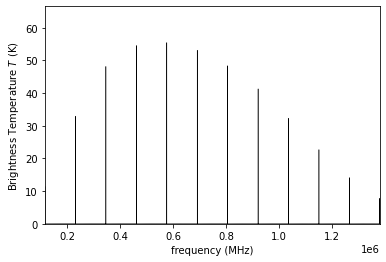

In [67]:
xclass_spectra.plotter()

# Molsim

Do the same, now using [molsim](https://github.com/bmcguir2/molsim)

In [68]:
from molsim.classes import Workspace, Catalog, Transition, Level, Molecule, PartitionFunction, Spectrum, Simulation, Continuum, Source, Observatory, Observation, Iplot, Trace
from molsim.file_handling import load_mol, load_obs, load_multi_obs

In [69]:
co = load_mol('co.cat', 
              type='SPCAT',
              qpart_file='co.qpart')
co_src = Source(column = Ntot, #column density in cm-2
                Tex = tkin, #excitation temperature in K
                dV = vwidthfwhm, #FWHM linewidth in km/s
                velocity = vcen, #vlsr in km/s
                size = 1e20, #source size in arcseconds; default is 1E20 so no beam dilution is considered.
                continuum = Continuum(params=tbg), 
                #a continuum object to define the background temperature. Default 2.7 K.
                #This can be substantially more flexible if needed - see the Continuum class object.
                )
co_sim = Simulation(  observation = Observation(), #a default Observation object (see note below)
                      source = co_src, #the source of emission
                      ll = frequencies.min(), #lower limit
                      ul = frequencies.max(), #upper limit
                      res = FreqStep, #resolution in MHz
                      mol = co, #molecule
)
molsim_sp = pyspeckit.Spectrum(xarr=co_sim.spectrum.freq_profile*u.MHz, data=co_sim.spectrum.int_profile*u.K, header={})

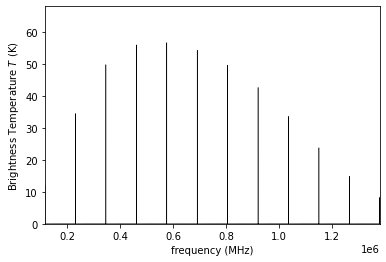

In [70]:
molsim_sp.plotter()

# pyspeckit

Now do the pyspeckit LTE model making using both CDMS and JPL catalogs.

In [71]:
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters, generate_model, generate_fitter

In [72]:
fmin_overall = xclass_spectra.xarr.min()
fmax_overall = xclass_spectra.xarr.max()

In [73]:
from astropy.table import Table

In [74]:
Jfreqs, Jaij, Jdeg, JEU, Jpartfunc = get_molecular_parameters('CO',
                                                              catalog='JPL',
                                                              fmin=fmin_overall,
                                                              fmax=fmax_overall)
def modfunc_JPL(xarr, vcen, width, tex, column, **kwargs):
    return generate_model(xarr, vcen=vcen, width=width, tex=tex, column=column, freqs=Jfreqs, aij=Jaij,
                          deg=Jdeg, EU=JEU, partfunc=Jpartfunc, tbg=tbg, **kwargs)

#print(Jpartfunc(tkin))
#Table([Jfreqs, Jdeg, JEU, Jaij])

In [75]:
freqs, aij, deg, EU, partfunc = get_molecular_parameters('CO, v=0',
                                                         catalog='CDMS',
                                                         fmin=fmin_overall,
                                                         fmax=fmax_overall)
def modfunc_CDMS(xarr, vcen, width, tex, column, **kwargs):
    return generate_model(xarr, vcen=vcen, width=width, tex=tex, column=column, freqs=freqs, aij=aij,
                          deg=deg, EU=EU, partfunc=partfunc, tbg=tbg, **kwargs)

#print(partfunc(tkin))
#Table([freqs, deg, EU, aij])

In [76]:
# sanity check: all CDMS & JPL EU's are the same
assert np.all(JEU[:9] - EU[:9] == 0)

In [77]:
# make sure that CDMS & JPL Einstein A coeffs come out the same
np.testing.assert_array_almost_equal(Jaij[:9], aij[:9])

In [78]:
from astropy import log
#log.setLevel('DEBUG')
JM = modfunc_JPL(xclass_spectra.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
CM = modfunc_CDMS(xclass_spectra.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
#log.setLevel('INFO')

In [79]:
model_JPL = pyspeckit.Spectrum(xarr=xclass_spectra.xarr, data=JM*u.K)
model_CDMS = pyspeckit.Spectrum(xarr=xclass_spectra.xarr, data=CM*u.K)

# Stick Spectra

Compare stick spectra for all

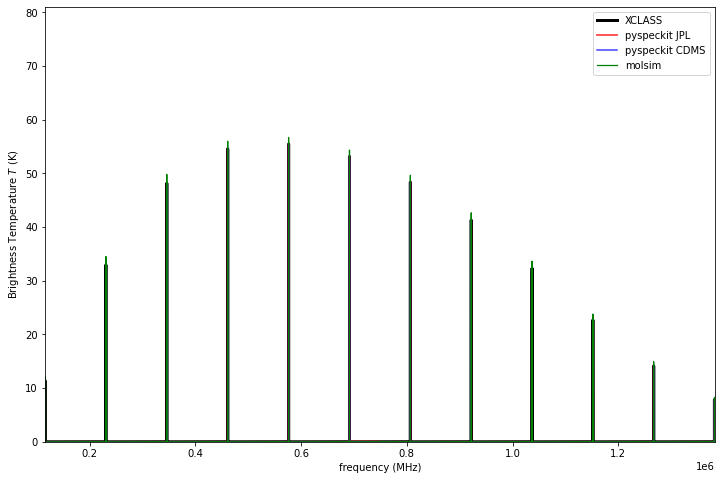

In [80]:
fig = pl.figure(figsize=(12,8))
xclass_spectra.plotter(figure=fig, linewidth=3, label='XCLASS')
ax = xclass_spectra.plotter.axis
model_JPL.plotter(clear=False, color='r', axis=ax, alpha=0.75, linewidth=1.75, label='pyspeckit JPL')
model_CDMS.plotter(clear=False, color='b', axis=ax, alpha=0.75, linewidth=1.5, label='pyspeckit CDMS')
molsim_sp.plotter(clear=False, color='g', axis=ax, linewidth=1.25, label='molsim')
ax.set_ylim([0,81])
pl.legend(loc='best')

Zooms on individual lines

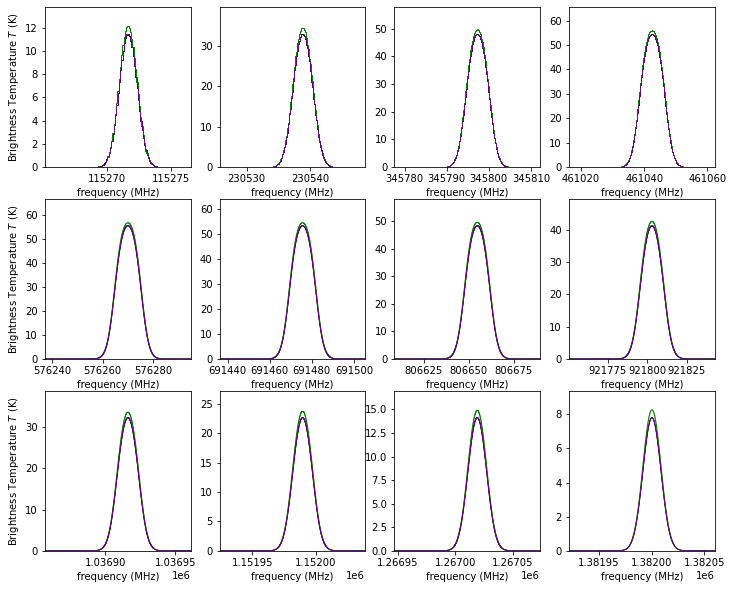

In [158]:
fig = pl.figure(figsize=(12,10))
for ii,(fmin, fmax) in enumerate(frequencies):
    if ii+1 > 12:
        break
    ax = pl.subplot(3,4,ii+1)
    
    xclass_spectra.plotter(axis=ax, clear=False, linewidth=1)

    molsim_sp.plotter(clear=False, color='g', axis=ax, xmin=fmin, xmax=fmax, linewidth=1)
    
    model_JPL.plotter(color='r', axis=ax, clear=False, xmin=fmin, xmax=fmax, linewidth=0.75)
    model_CDMS.plotter(color='b', axis=ax, clear=False, xmin=fmin, xmax=fmax)
    #ax.axhline(tkin)
    #ax.set_ylim(-1, tkin+1)
    #if ii <= 12:
    #    ax.set_xlabel('')
    #    ax.set_xticklabels([])
    #else:
    #     ax.set_xlabel("$V_{LSR}$ [km s$^{-1}$]")
    #if ii % 4 == 1:
    #    ylim = ax.set_ylabel("Fractional Difference")
    if ii % 4 != 0:
        ax.set_ylabel('')

The integrals of each line are below, and fractional differences at the end of the line:

In [82]:
for ii,(fmin, fmax) in enumerate(frequencies):
    fmin, fmax = u.Quantity([fmin, fmax], u.MHz)
    xc_sum = xclass_spectra.slice(fmin, fmax).data.sum()

    molsim_sum = molsim_sp.slice(fmin, fmax).data.sum()
    
    jplsum = model_JPL.slice(fmin, fmax).data.sum()
    cdmssum = model_CDMS.slice(fmin, fmax).data.sum()
    print(f"{ii:3d} {xc_sum:10.5f} {molsim_sum:10.5f} {jplsum:10.5f} {cdmssum:10.5f}  fracdif: {(xc_sum-cdmssum)/cdmssum:10.6g} {(molsim_sum-cdmssum)/cdmssum:10.6g}")

  0  202.33428  214.59241  202.32447  202.32447  fracdif: 4.85192e-05   0.060635
  1 1234.94028 1298.91052 1234.89464 1234.89464  fracdif: 3.69568e-05  0.0518391
  2 2896.49106 3021.23215 2896.42951 2896.42951  fracdif: 2.12513e-05  0.0430884
  3 4610.68894 4782.37688 4610.63669 4610.63669  fracdif: 1.13331e-05  0.0372487
  4 6004.02934 6212.41790 6003.99567 6003.99567  fracdif: 5.60731e-06  0.0347139
  5 6880.04831 7121.04350 6880.66672 6880.03260  fracdif: 2.28304e-06  0.0350305
  6 7120.55014 7388.89383 7120.57082 7120.57082  fracdif: -2.90362e-06  0.0376828
  7 6673.88968 6955.19448 6673.95582 6673.95582  fracdif: -9.90979e-06  0.0421397
  8 5620.60886 5888.15471 5620.71380 5620.71380  fracdif: -1.86713e-05  0.0475813
  9 4213.12647 4436.35699 4213.27164 4213.27164  fracdif: -3.44552e-05  0.0529482
 10 2799.62885 2960.39970 2799.75691 2799.75691  fracdif: -4.57402e-05  0.0573774
 11 1653.44839 1753.59724 1653.55281 1653.55281  fracdif: -6.31476e-05  0.0605027


In [83]:
pl.figure()
xclass_spectra.plotter(axis=ax, clear=False, linewidth=1)

molsim_sp.plotter(clear=False, color='g', axis=ax, xmin=fmin, xmax=fmax, linewidth=1)

model_JPL.plotter(color='r', axis=ax, clear=False, xmin=fmin, xmax=fmax, linewidth=0.75)
model_CDMS.plotter(color='b', axis=ax, clear=False, xmin=fmin, xmax=fmax)
ax.axhline(tkin)
ax.set_ylim(-1, tkin+1)

(-1.0, 80.842254347)

<Figure size 432x288 with 0 Axes>

In [84]:
# calculate pyspeckit models on molspec's grid
JMms = modfunc_JPL(molsim_sp.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
CMms = modfunc_CDMS(molsim_sp.xarr, vcen, width=vwidth, tex=tkin, column=Ntot)
model_JPL_ms = pyspeckit.Spectrum(xarr=molsim_sp.xarr, data=JMms*u.K)
model_CDMS_ms = pyspeckit.Spectrum(xarr=molsim_sp.xarr, data=CMms*u.K)

Look at the relative difference between the XCLASS spectra and the pyspeckit JPL spectra

In [85]:
diffX = (model_JPL - xclass_spectra)
diffX.data = diffX.data / model_JPL.data
diffM = (model_JPL_ms - molsim_sp)
diffM.data = diffM.data / model_JPL_ms.data

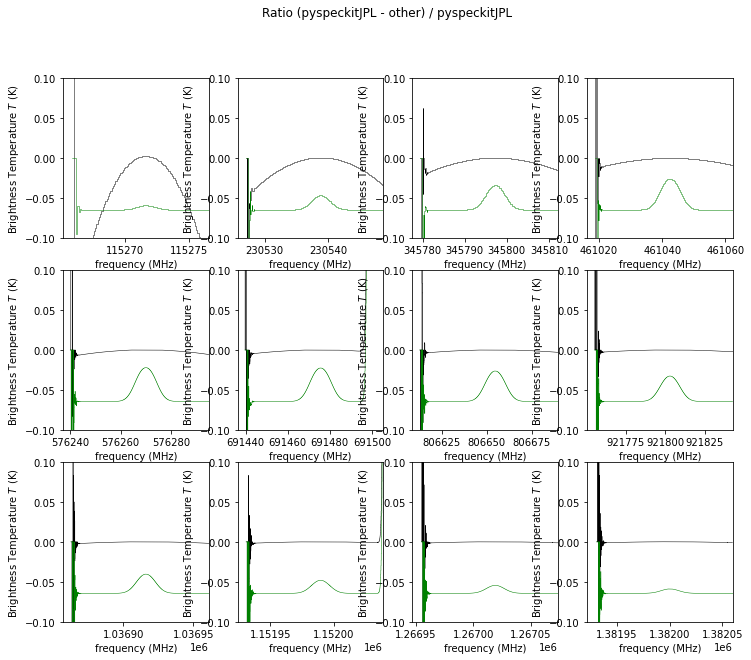

In [86]:
fig = pl.figure(figsize=(12,10))
fig.suptitle("Ratio (pyspeckitJPL - other) / pyspeckitJPL")
for ii,(fmin, fmax) in enumerate(frequencies):
    if ii+1 > 12:
        break
    ax = pl.subplot(3,4,ii+1)
    diffX.plotter(axis=ax, xmin=fmin, xmax=fmax, clear=False)
    diffM.plotter(axis=ax, xmin=fmin, xmax=fmax, clear=False, color='g')
    ax.set_ylim(-0.1, 0.1)    

# Zoom in on one line to show the systematic differences in detail

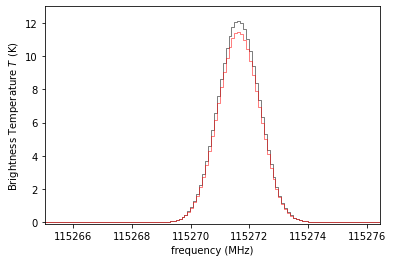

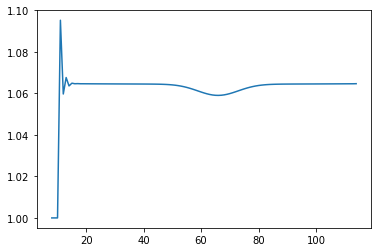

In [87]:
molsim_sp.slice(frequencies[0][0]*u.MHz, frequencies[0][1]*u.MHz).plotter()
model_JPL_ms.slice(frequencies[0][0]*u.MHz, frequencies[0][1]*u.MHz).plotter(axis=pl.gca(), clear=False, color='r')
pl.ylim(-0.1, 13)
pl.figure()
pl.plot(molsim_sp.slice(frequencies[0][0]*u.MHz, frequencies[0][1]*u.MHz).data / model_JPL_ms.slice(frequencies[0][0]*u.MHz, frequencies[0][1]*u.MHz).data)

### Absolute Differences

Difference between pyspeckit JPL and others

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
A

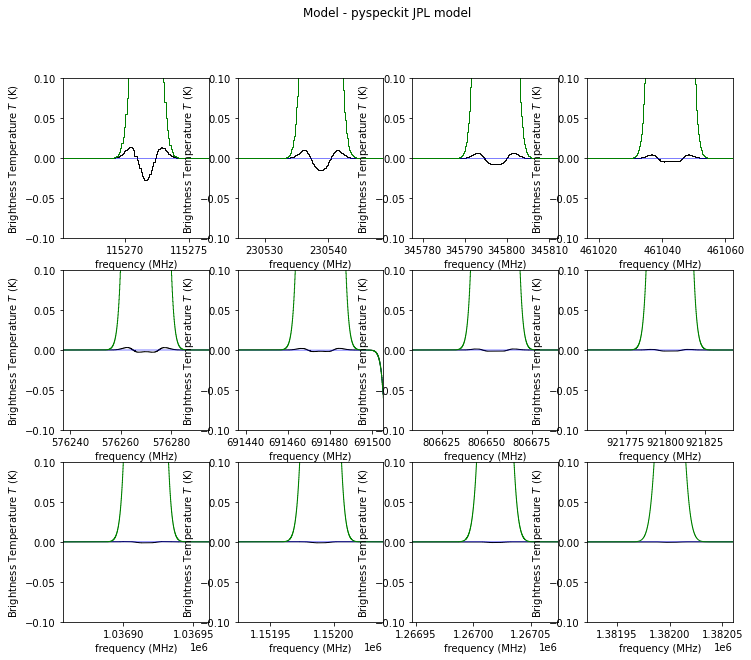

In [88]:
fig = pl.figure(figsize=(12,10))
fig.suptitle("Model - pyspeckit JPL model")
for ii,(fmin, fmax) in enumerate(frequencies):
    if ii+1 > 12:
        break
    ax = pl.subplot(3,4,ii+1)
    (xclass_spectra - model_JPL).plotter(axis=ax, clear=False, linewidth=1)
    #model_JPL.plotter(color='r', axis=ax, clear=False, xmin=fmin, xmax=fmax, linewidth=0.75)
    (model_CDMS - model_JPL).plotter(color='b', axis=ax, clear=False, xmin=fmin, xmax=fmax)
    (molsim_sp - model_JPL_ms).plotter(clear=False, color='g', axis=ax, xmin=fmin, xmax=fmax, linewidth=1)
    ax.axhline(tkin)
    ax.set_ylim(-0.1,0.1)

In [89]:
JMms_tau = modfunc_JPL(molsim_sp.xarr, vcen, width=vwidth, tex=tkin, column=Ntot, get_tau=True)

In [90]:
taus = []
for ii,(fmin, fmax) in enumerate(frequencies):
    keep = (molsim_sp.xarr > fmin*u.MHz) & (molsim_sp.xarr < fmax*u.MHz)
    tau = JMms_tau[keep].max()
    print(ii, (fmin+fmax)/2., tau)
    taus.append(tau)

0 115270.81756266067 0.16290839757147008
1 230537.23154 0.5872691707431507
2 345794.8372467003 1.1113539750547927
3 461039.2313974394 1.5499773163414183
4 576266.0096068983 1.773183717968348
5 691470.7713897456 1.7440973277115002
6 806649.1171606467 1.513227246216555
7 921796.6273343333 1.175395427933255
8 1036908.9366253568 0.8255375191265136
9 1151981.6120484932 0.5276995208477956
10 1267010.2626183801 0.3085456495097195
11 1381990.4983496498 0.1655354077330334


In [91]:
# recover the optical depths from XCLASS

xclass_taus = {}
# _ is (modeldata, log, TransEnergies, IntOpt, JobDir) 
for _ in results:
    IntOpt = _[3] 
    for mol in IntOpt[1]:
        frq, tau_thismol = mol[2].T
        if mol[0] not in xclass_taus:
            xclass_taus[mol[0]] = []
            #print(mol[0], frq.min(), frq.max())
        for ii,(fmin, fmax) in enumerate(frequencies):
            keep = (frq > fmin) & (frq < fmax)
            if any(keep):
                tauval = tau_thismol[keep].max()
                #print(ii, (fmin+fmax)/2., tauval)
                xclass_taus[mol[0]].append(tauval)

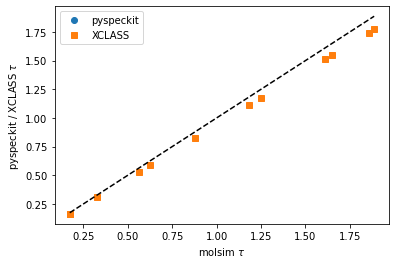

In [92]:
pl.plot(co_sim.spectrum.tau, taus, 'o', label='pyspeckit')
pl.plot(co_sim.spectrum.tau, xclass_taus['CO;v=0;'], 's', label='XCLASS')
pl.plot([co_sim.spectrum.tau.min(), co_sim.spectrum.tau.max()],
        [co_sim.spectrum.tau.min(), co_sim.spectrum.tau.max()],
        'k--')
pl.xlabel('molsim $\\tau$')
pl.ylabel('pyspeckit / XCLASS $\\tau$')
pl.legend(loc='best')

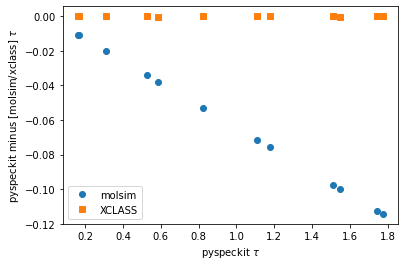

In [93]:
pl.plot(taus, np.array(taus) - co_sim.spectrum.tau, 'o', label='molsim')
pl.plot(taus, np.array(taus) - xclass_taus['CO;v=0;'], 's', label='XCLASS')
pl.xlabel('pyspeckit $\\tau$')
pl.ylabel('pyspeckit minus [molsim/xclass] $\\tau$')
pl.legend(loc='best')

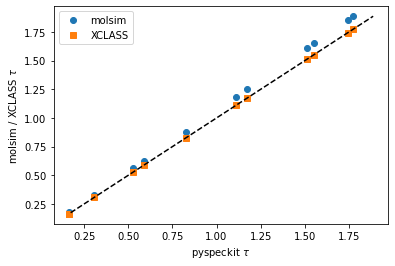

In [94]:
pl.plot(taus, co_sim.spectrum.tau, 'o', label='molsim')
pl.plot(taus, xclass_taus['CO;v=0;'], 's', label='XCLASS')
pl.plot([co_sim.spectrum.tau.min(), co_sim.spectrum.tau.max()],
        [co_sim.spectrum.tau.min(), co_sim.spectrum.tau.max()],
        'k--')
pl.xlabel('pyspeckit $\\tau$')
pl.ylabel('molsim / XCLASS $\\tau$')
pl.legend(loc='best')

# Histograms of Ratios

These are the ratios of the optical depths computed with the different codes.

There are systematic differences.

array([1.06460807, 1.06459286, 1.06461873, 1.06459238, 1.06446158,
       1.06443014, 1.06442582, 1.0644456 , 1.06441193, 1.06439849,
       1.06439272, 1.06437528])

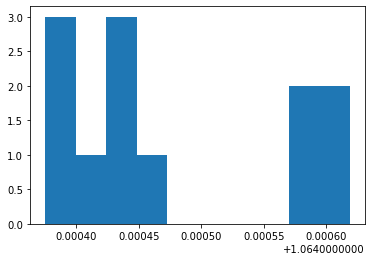

In [95]:
pl.hist(np.array(co_sim.spectrum.tau)/np.array(taus),  label='molsim')
np.array(co_sim.spectrum.tau)/np.array(taus)

(array([1., 0., 0., 0., 1., 5., 2., 1., 1., 1.]),
 array([0.99971115, 0.99975522, 0.99979929, 0.99984336, 0.99988743,
        0.9999315 , 0.99997557, 1.00001963, 1.0000637 , 1.00010777,
        1.00015184]),
 <BarContainer object of 10 artists>)

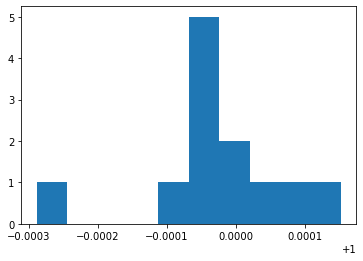

In [96]:
pl.hist(np.array(xclass_taus['CO;v=0;']) / np.array(taus), label='XCLASS')

Text(0.5, 0, 'Ratio molsim / XCLASS tau')

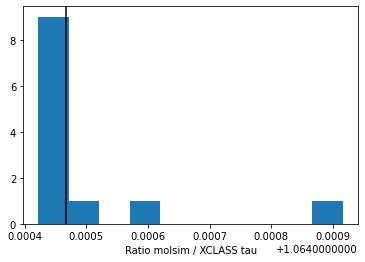

In [97]:
pl.hist(np.array(co_sim.spectrum.tau / np.array(xclass_taus['CO;v=0;'])))
pl.axvline(np.sqrt(2 * np.pi / (8*np.log(2))), color='k')
pl.xlabel("Ratio molsim / XCLASS tau")

In terms of the equations implemented, the `tau` stored internally by pyspeckit & molsim are different:

$$\tau_{pyspeckit} = \frac{\nu dV \phi_\nu}{c} \tau_{molsim}$$

# AIJ

The $A_{ij}$ are consistent between molsim and pyspseckit
(these aij are from CDMS, but JPL is consistent)

In [98]:
co_sim.aij /  10**aij

array([1.00003129, 1.00001107, 1.00002006, 1.00001982, 1.00000811,
       1.00000899, 1.00000086, 0.99999152, 0.99998784, 0.99997709,
       0.99996649, 0.99995679])

# Degeneracy
Again, consistent

In [99]:
co_sim.gup / deg

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# E_U

In [100]:
from astropy import constants

In [101]:
co_sim.eup / (EU*u.erg/constants.k_B).to(u.K)

<Quantity [0.99999131, 1.00000694, 0.99999945, 0.99999832, 1.00000123,
           0.99999927, 0.99999993, 1.00000052, 0.99999957, 1.00000001,
           1.00000018, 1.00000002] 1 / K>

# Partition Function

The molsim partition function is consistent (but checking this revealed that pyspeckit was previously incorrectly using log interpolation)

In [102]:
co.qpart.q(tkin) / partfunc(tkin), co.qpart.q(tkin) /  Jpartfunc(tkin)

(1.0000398240989359, 1.0000398240989359)

# Check for systematic variations with column (optical depth) and temperature


In [150]:
temperatures = [10, 50, 100, 300]
columns = [1e17, 3e17, 5e17, 1e18]

FreqMin, FreqMax = frequencies[0]

temcol_results = {}
for tem in temperatures:
    temcol_results[tem] = {}
    for col in columns:
        print(col, tem)
        set_xclass_parameters(tkin=tem, Ntot=col)
        modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
        JM_ = modfunc_JPL(modeldata.T[0]*u.MHz, vcen, width=vwidth, tex=tem, column=col)
        model_JPL_ = pyspeckit.Spectrum(xarr=modeldata.T[0]*u.MHz, data=JM_*u.K, header={})
        temcol_results[tem][col] = {'xclass':
                               {'modeldata':modeldata, 'log':log, 'TransEnergies':TransEnergies, 'IntOpt':IntOpt, 'JobDir':JobDir, 
                                'sp': pyspeckit.Spectrum(data=modeldata.T[1]*u.K, xarr=modeldata.T[0]*u.MHz, header={})},
                               'jpl': model_JPL_}

1e+17 10
3e+17 10
5e+17 10
1e+18 10
1e+17 50
3e+17 50
5e+17 50
1e+18 50
1e+17 100
3e+17 100
5e+17 100
1e+18 100
1e+17 300
3e+17 300
5e+17 300
1e+18 300


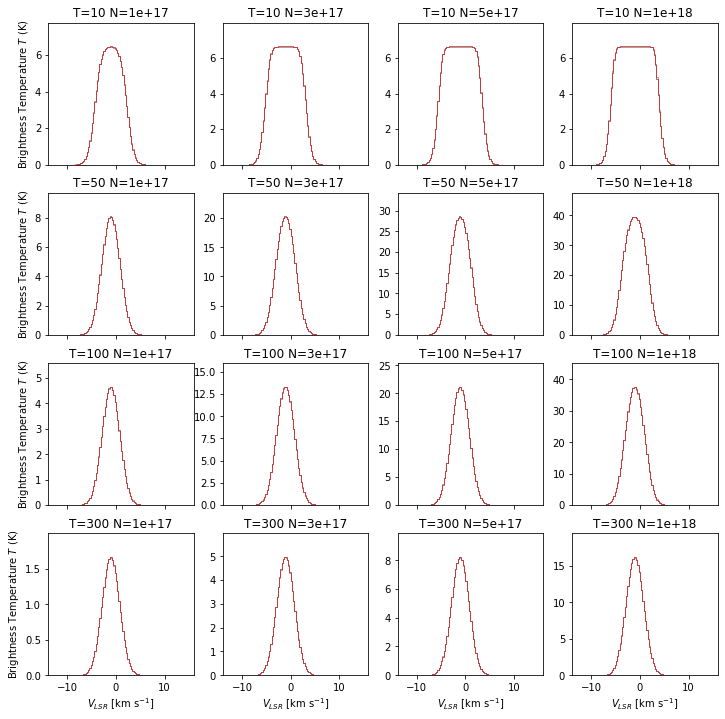

In [151]:
pl.figure(figsize=(12,12))
ii = 1
for tem in temperatures:
    for col in columns:
        ax = pl.subplot(4,4,ii)
        temcol_results[tem][col]['xclass']['sp'].xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=115271.2018*u.MHz)
        temcol_results[tem][col]['jpl'].xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=115271.2018*u.MHz)
        temcol_results[tem][col]['xclass']['sp'].plotter(axis=ax)
        temcol_results[tem][col]['jpl'].plotter(axis=ax, clear=False, color='r')
        ax.set_title(f"T={tem} N={col}")
        if ii <= 12:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
             ax.set_xlabel("$V_{LSR}$ [km s$^{-1}$]")
        if ii % 4 == 1:
            ylim = ax.get_ylim()
        if ii % 4 != 1:
            ax.set_ylabel('')
        ii += 1

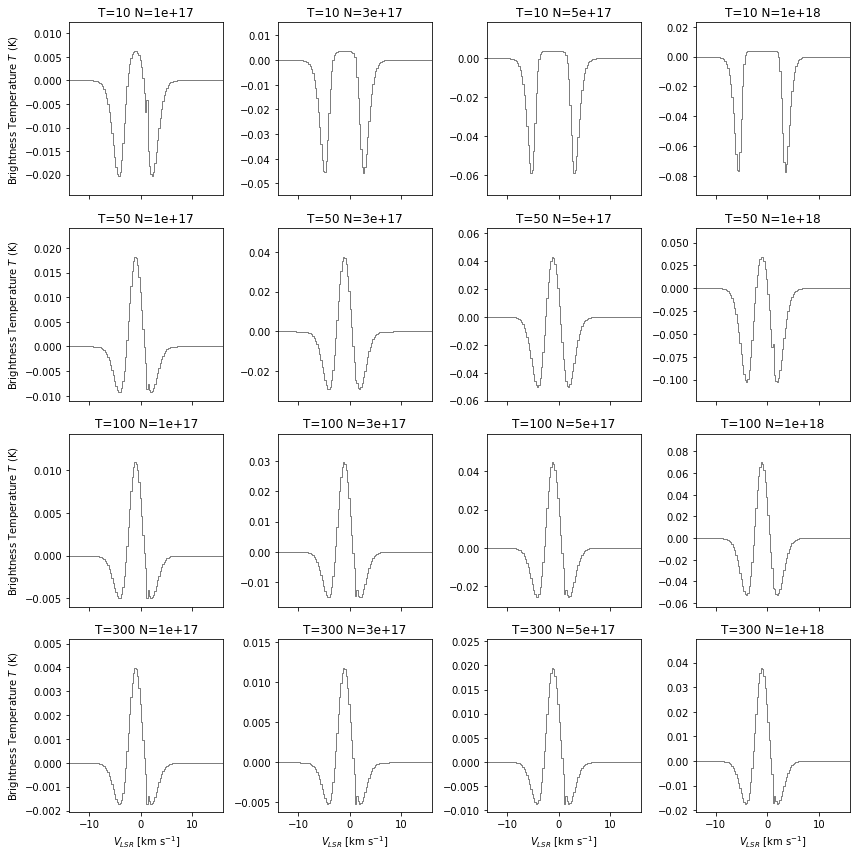

In [152]:
pl.figure(figsize=(12,12))
ii = 1
for tem in temperatures:
    for col in columns:
        ax = pl.subplot(4,4,ii)
        diff = (temcol_results[tem][col]['xclass']['sp'] - temcol_results[tem][col]['jpl'])
        diff.plotter(axis=ax)
        ax.set_title(f"T={tem} N={col}")
        if ii <= 12:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
             ax.set_xlabel("$V_{LSR}$ [km s$^{-1}$]")
        if ii % 4 == 1:
            ylim = ax.get_ylim()
        if ii % 4 != 1:
            ax.set_ylabel('')
            #ax.set_yticklabels('')
            #ax.set_ylim(*ylim)
        ii += 1
pl.tight_layout()

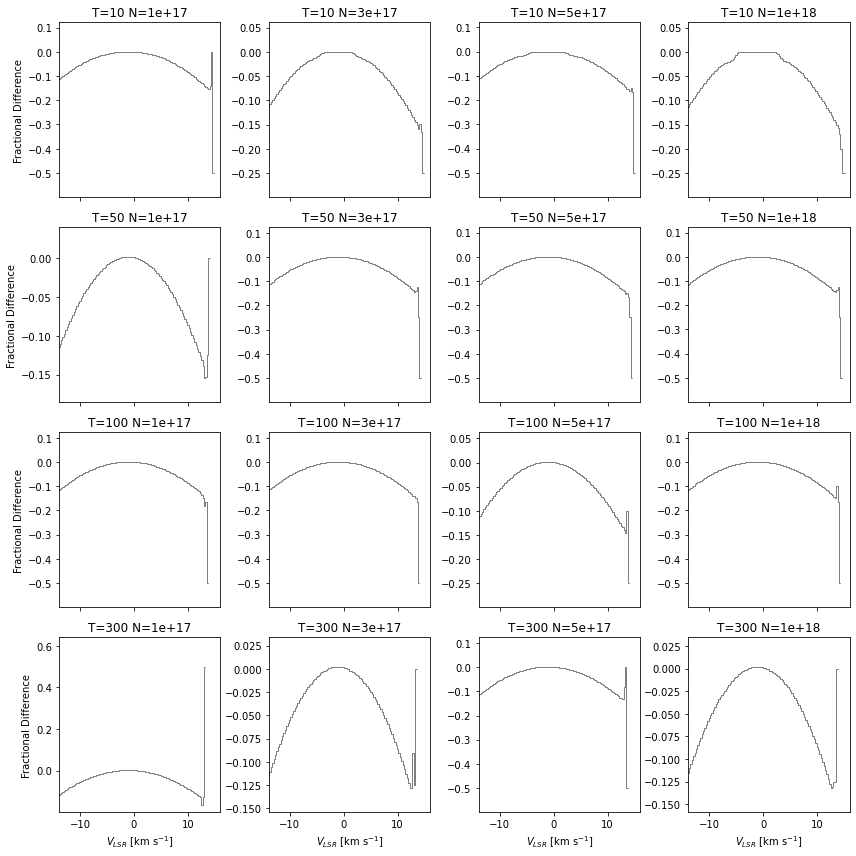

In [153]:
pl.figure(figsize=(12,12))
ii = 1
for tem in temperatures:
    for col in columns:
        ax = pl.subplot(4,4,ii)
        diff = (temcol_results[tem][col]['xclass']['sp'] - temcol_results[tem][col]['jpl'])
        diff.data = diff.data / temcol_results[tem][col]['jpl'].data
        diff.plotter(axis=ax)
        ax.set_title(f"T={tem} N={col}")
        if ii <= 12:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
             ax.set_xlabel("$V_{LSR}$ [km s$^{-1}$]")
        if ii % 4 == 1:
            ylim = ax.set_ylabel("Fractional Difference")
        if ii % 4 != 1:
            ax.set_ylabel('')
            #ax.set_yticklabels('')
            #ax.set_ylim(*ylim)
        ii += 1
pl.tight_layout()

# Check for systematic linewidth difference

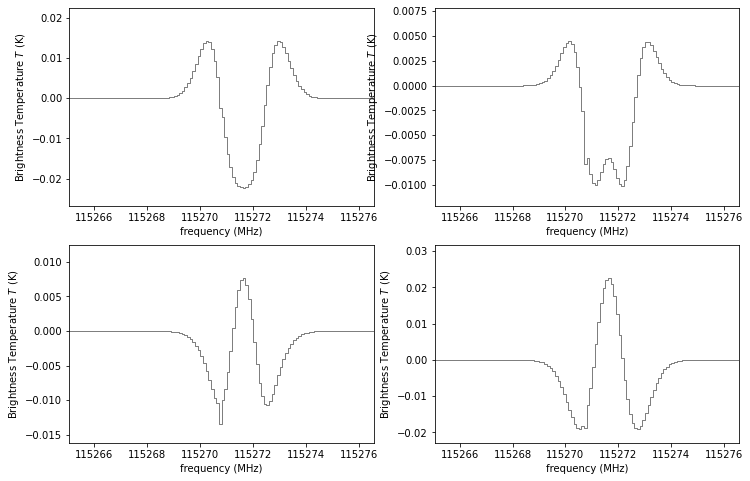

In [156]:
tem = 50
col = 3e17

FreqMin, FreqMax = frequencies[0]

pl.figure(figsize=(12,8))
ii=1
for scalefactor in (1.001, 1.002, 1.003, 1.004):
    set_xclass_parameters(tkin=tem, Ntot=col)
    modeldata, log, TransEnergies, IntOpt, JobDir = myxclass_call(FreqMin=FreqMin, FreqMax=FreqMax)
    JM_ = modfunc_JPL(modeldata.T[0]*u.MHz, vcen, width=vwidth*scalefactor, tex=tem, column=col)
    Jsp = pyspeckit.Spectrum(xarr=modeldata.T[0]*u.MHz, data=JM_*u.K, header={})
    xsp = pyspeckit.Spectrum(data=modeldata.T[1]*u.K, xarr=modeldata.T[0]*u.MHz, header={})
    diff = xsp - Jsp
    diff.plotter(axis=pl.subplot(2,2,ii))
    ii += 1